In [17]:
from model.deeponet import *
import numpy as np
from src.collision_operator_1D import CollisionOperator1D
from src.collision_operator_3D import CollisionOperator3D
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

In [18]:
gpu_id='3'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

use_cuda = torch.cuda.is_available()
print("Is available to use cuda? : ",use_cuda)
if use_cuda:
    print("-> GPU number ",gpu_id)

Is available to use cuda? :  True
-> GPU number  3


## 1D case

In [35]:
dimension=1
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    '3_128_3_128_wo_bias',
    '3_128_3_128_w_bias',
    '3_128_3_128_soft_lamb01',
    '3_128_3_128_hard_gram',
    '3_128_3_128_hard_special'
]

In [36]:
args=torch.load(f'results/{dimension}D/'+'entropy/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [37]:
### Data
## Load data
train_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_train_data.npz')
test_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_test_data.npz')

train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
if dimension==1:
    Q = CollisionOperator1D(integration_order)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperator3D(integration_order)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

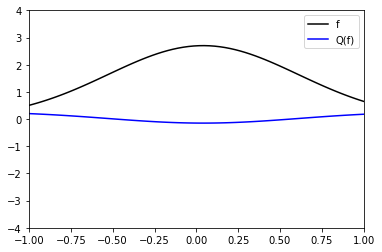

In [38]:
idx=np.random.randint(train_data_f.shape[0])
plt.plot(grid.cpu(), train_data_f[idx], 'k')
plt.plot(grid.cpu(), train_data_Q[idx], 'b')
plt.legend(["f", "Q(f)"])
plt.xlim(-1,1)
plt.ylim(-4,4)
plt.show()

In [39]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/1D/'+'entropy/'+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/1D/'+'entropy/'+list_filename[idx_model]+'/best.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

In [40]:
save_model.keys()

dict_keys(['state_dict', 'best_loss', 'best_rel_train', 'best_rel_test', 'epoch'])

In [41]:
def final_lr(epochs, lr, step_size, lr_sche):
    return lr, lr*lr_sche**(epochs/step_size)
 

In [42]:
final_lr(10000,1e-3,100,0.9)

(0.001, 2.6561398887587545e-08)

In [43]:
final_lr(10000,1e-3,500,0.9)

(0.001, 0.00012157665459056935)

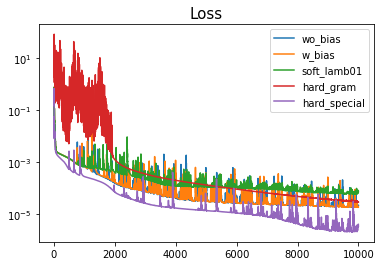

In [44]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/1D/'+'entropy/'+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

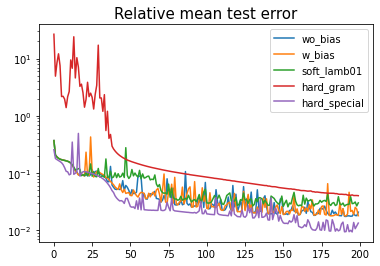

In [45]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/1D/'+'entropy/'+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

### Plot basis

In [46]:
all_basis=[]
add_one_basis=[False,True,True,True,True]
for idx in range(len(models)):
    basis=models[idx].get_basis(grid, add_one_basis=add_one_basis[idx]).transpose(0,1).detach().cpu()
    all_basis.append(basis)
    

In [47]:
all_basis[0].shape

torch.Size([128, 100])

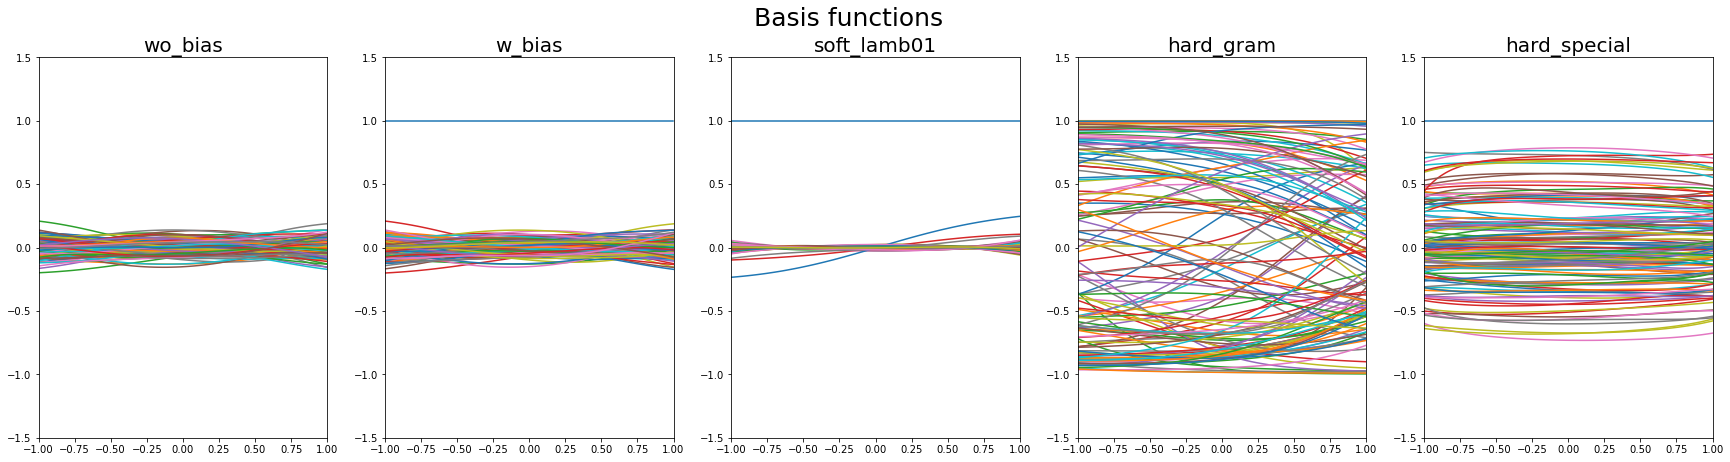

In [48]:
plt.figure(figsize=(30,7))
plt.suptitle(r'Basis functions', fontsize=25)
for idx in range(len(models)):
    ax=plt.subplot(1,len(models),idx+1)
    ax.set_title(names[idx], fontsize=20)
    for i in range(n_basiss[idx]):
        ax.plot(grid.detach().cpu(),all_basis[idx][i], label='{}-th basis'.format(i))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1.5,1.5)
# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.show()

In [49]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

Mean_test error of total test data for wo_bias     =1.76E-02
Mean_test error of total test data for w_bias      =1.79E-02
Mean_test error of total test data for soft_lamb01 =2.63E-02
Mean_test error of total test data for hard_gram   =1.50E+00
Mean_test error of total test data for hard_special=9.42E-03


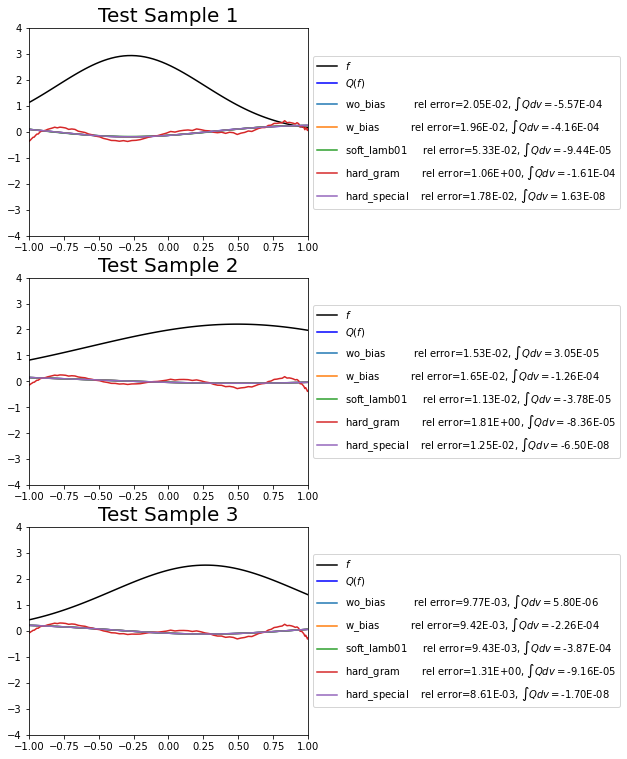

In [50]:
num_plot=3
plt.figure(figsize=(5,13))

for plot_idx in range(num_plot):
    ax=plt.subplot(num_plot,1,plot_idx+1)
    ax.set_title("Test Sample {}".format(str(plot_idx+1)), fontsize=20)
    data_idx=np.random.randint(test_data_f.shape[0])
    
    ax.plot(grid.detach().cpu(), test_data_f[data_idx], '-k', label=r'$f$')
    ax.plot(grid.detach().cpu(), test_data_Q[data_idx], 'b', markersize=3, label=r'$Q(f)$')
    ax.set_xlim(-1,1)
    ax.set_ylim(-4,4)
    for idx in range(len(models)):
        models[idx]
        prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
        ax.plot(grid.detach().cpu(), prediction, label=r"{:15s} rel error={:.2E}, $\int Q dv=${:.2E}".format(names[idx],rel_L2_error(prediction, test_data_Q[data_idx]),torch.sum(prediction*quad_w.detach().cpu())))
        if plot_idx==0:
            prediction_all=models[idx](test_data_f.cuda(), grid).squeeze().detach().cpu()
            print("Mean_test error of total test data for {:12s}={:.2E}".format(names[idx], rel_L2_error(prediction_all, test_data_Q).mean()))
#         print(names[idx])
#         print("Rel error : {:.3f}".format(rel_L2_error(prediction, test_data_Q[data_idx])))
#         print(r'$\int Q dv=${:.5f}'.format(torch.sum(prediction*quad_w.detach().cpu())))
#         print(" ")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()

## 3D case - Not yet...

In [3]:
dimension=3
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    '3_50_3_50_wo_bias',
    '3_50_3_50_w_bias',
    '3_50_3_50_soft_lamb01',
    '3_50_3_50_hard_gram',
    '3_50_3_50_hard_special'
]

In [4]:
args=torch.load(f'results/{dimension}D/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [5]:
### Data
## Load data
train_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_train_data.npz')
test_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_test_data.npz')

train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
if dimension==1:
    Q = CollisionOperator1D(integration_order)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperator3D(integration_order)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

In [79]:
torch.topk(train_data_f.reshape(-1),10)

torch.return_types.topk(
values=tensor([8.4280, 7.5649, 7.2730, 7.0233, 6.6239, 6.5824, 6.4659, 6.2260, 6.2183,
        6.0437]),
indices=tensor([58660, 24155, 58670, 58650, 37045, 25944,  5705, 16695, 19454,  9794]))

In [80]:
torch.mean(train_data_f)

tensor(0.0879)

In [71]:
torch.min(train_data_Q)

tensor(-8.3484)

In [82]:
torch.max(train_data_Q)

tensor(0.0796)

In [103]:
np.arccos(-1)

3.141592653589793

In [104]:
np.arccos(1)

0.0

In [108]:
Q.get_quad_pts_polar()[0]

array([[2.91264835, 2.616073  , 2.31775399, 2.01905333, 1.72022616,
        1.4213665 , 1.12253933, 0.82383866, 0.52551966, 0.2289443 ],
       [2.91264835, 2.616073  , 2.31775399, 2.01905333, 1.72022616,
        1.4213665 , 1.12253933, 0.82383866, 0.52551966, 0.2289443 ],
       [2.91264835, 2.616073  , 2.31775399, 2.01905333, 1.72022616,
        1.4213665 , 1.12253933, 0.82383866, 0.52551966, 0.2289443 ],
       [2.91264835, 2.616073  , 2.31775399, 2.01905333, 1.72022616,
        1.4213665 , 1.12253933, 0.82383866, 0.52551966, 0.2289443 ],
       [2.91264835, 2.616073  , 2.31775399, 2.01905333, 1.72022616,
        1.4213665 , 1.12253933, 0.82383866, 0.52551966, 0.2289443 ],
       [2.91264835, 2.616073  , 2.31775399, 2.01905333, 1.72022616,
        1.4213665 , 1.12253933, 0.82383866, 0.52551966, 0.2289443 ],
       [2.91264835, 2.616073  , 2.31775399, 2.01905333, 1.72022616,
        1.4213665 , 1.12253933, 0.82383866, 0.52551966, 0.2289443 ],
       [2.91264835, 2.616073  , 2.3177539

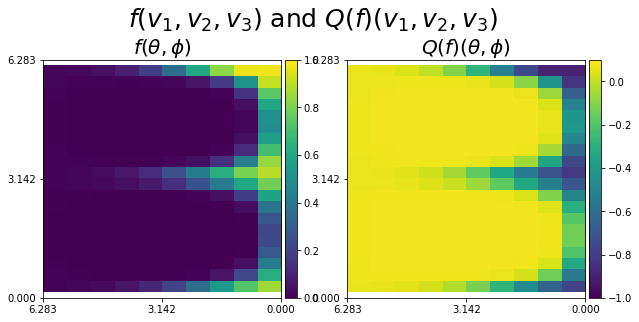

In [200]:
idx=np.random.randint(train_data_f.shape[0])

from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(10,5))
plt.suptitle(r'$f(v_1,v_2,v_3)$ and $Q(f)(v_1,v_2,v_3)$', fontsize=25)
ax=plt.subplot(1,2,1)
ax.set_title(r'$f(\theta,\phi)$', fontsize=20)
im=ax.imshow(train_data_f[idx].reshape(20,10), vmin=0, vmax=1, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

ax=plt.subplot(1,2,2)
ax.set_title(r'$Q(f)(\theta,\phi)$', fontsize=20)
im=ax.imshow(train_data_Q[idx].reshape(20,10), vmin=-1, vmax=0.1, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

In [130]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load(f'results/{dimension}D/'+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load(f'results/{dimension}D/'+list_filename[idx_model]+'/final.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

In [131]:
save_model.keys()

dict_keys(['state_dict', 'loss', 'rel_train', 'rel_test', 'epoch', 'optimizer'])

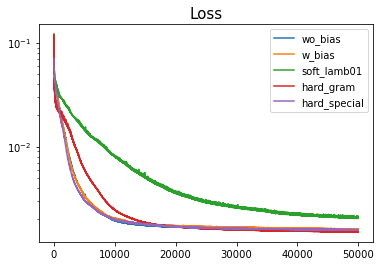

In [132]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load(f'results/{dimension}D/'+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

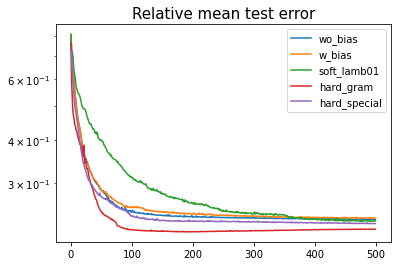

In [133]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load(f'results/{dimension}D/'+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

### Plot basis

In [134]:
all_basis=[]
add_one_basis=[False,True,True,True,True]
for idx in range(len(models)):
    basis=models[idx].get_basis(grid, add_one_basis=add_one_basis[idx]).transpose(0,1).detach().cpu()
    all_basis.append(basis)
    

In [138]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

wo_bias     => (sample) test error=1.36E-01, Qdv=-1.64E-03 & (All) test error=2.35E-01
w_bias      => (sample) test error=1.39E-01, Qdv=-4.16E-03 & (All) test error=2.38E-01
soft_lamb01 => (sample) test error=1.15E-01, Qdv=-1.59E-02 & (All) test error=2.33E-01
hard_gram   => (sample) test error=1.38E-01, Qdv=2.33E-07 & (All) test error=2.21E-01
hard_special=> (sample) test error=1.31E-01, Qdv=7.45E-09 & (All) test error=2.29E-01


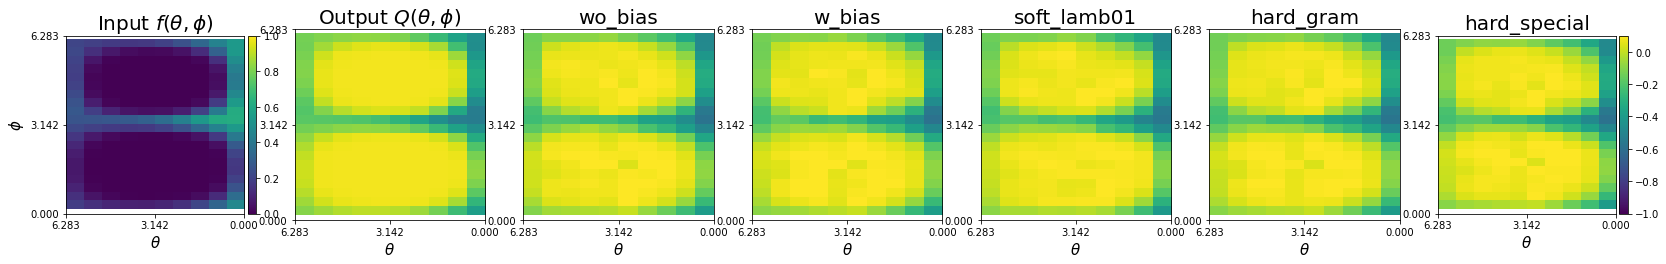

In [202]:
data_idx=np.random.randint(test_data_f.shape[0])

plt.figure(figsize=(28,5))

ax=plt.subplot(1,7,1)
ax.set_title(r"Input $f(\theta,\phi)$", fontsize=20)
im=ax.imshow(test_data_f[data_idx].reshape(20,10), vmin=0, vmax=1, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\theta$',fontsize=15)
ax.set_ylabel(r'$\phi$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

ax=plt.subplot(1,7,2)
ax.set_title(r"Output $Q(\theta,\phi)$", fontsize=20)
im=ax.imshow(test_data_Q[data_idx].reshape(20,10), vmin=-1, vmax=0.1, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
ax.set_xlabel(r'$\theta$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi,2*np.pi])

for idx in range(len(models)):
    ax=plt.subplot(1,7,idx+2+1)
    prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
    ax.set_title("{}".format(names[idx]), fontsize=20)
    im=ax.imshow(prediction.reshape(20,10), vmin=-1, vmax=0.1, extent=(2*np.pi,0,np.pi/(2*integration_order),np.pi*(4*integration_order-1)/(2*integration_order)))
    ax.set_xlabel(r'$\theta$',fontsize=15)
    ax.set_xticks([0,np.pi,2*np.pi])
    ax.set_yticks([0,np.pi,2*np.pi])
    prediction_all=models[idx](test_data_f.cuda(), grid).squeeze().detach().cpu()
    print("{:12s}=> (sample) test error={:.2E}, Qdv={:.2E} & (All) test error={:.2E}".format(names[idx],rel_L2_error(prediction, test_data_Q[data_idx]),torch.sum(prediction*quad_w.detach().cpu()), rel_L2_error(prediction_all, test_data_Q).mean()))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

In [205]:
prediction.shape

torch.Size([200])

In [206]:
test_data_Q[data_idx].shape

torch.Size([200])

In [209]:
((prediction-test_data_Q[data_idx])**2).mean()

tensor(0.0004)

In [210]:
((test_data_Q[data_idx])**2).mean()

tensor(0.0253)

In [212]:
(((prediction-test_data_Q[data_idx])**2).mean()/((test_data_Q[data_idx])**2).mean())**0.5

tensor(0.1312)

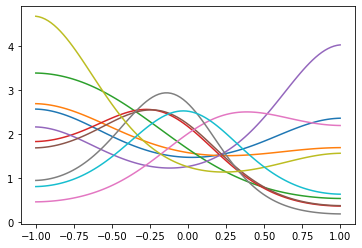

In [26]:
for i in range(10):
    plt.plot(np.linspace(-1,1,100),np.genfromtxt('data/'+f'{dimension}D/'+'entropy'+'_train_data.csv', delimiter=',')[i])